In [1]:
import os 
import sys
import random
import math
import numpy as np
import pandas as pd 
import glob 
import json
from matplotlib import pyplot as plt

import cv2
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm

In [2]:
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'stage_1_train_images')
TEST_DIR = os.path.join(DATA_DIR, 'stage_1_test_images')

MODEL_DIR = '../model/Mask_RCNN'
COCO_WEIGHTS_PATH = os.path.join(MODEL_DIR, 'mask_rcnn_coco.h5')
ORIG_SIZE = 1024

In [3]:
# Import Mask RCNN
sys.path.append(os.path.join(MODEL_DIR))  # To find local version of the library
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [4]:
from pneumonia import PneumoniaDataset, PneumoniaConfig
from functions import parse_dataset

In [5]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

config = PneumoniaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [6]:
# Parse dataset
annotations = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
image_fps, image_annotations = parse_dataset(TRAIN_DIR, annotations)

In [7]:
# Split dataset into training vs. validation dataset 
# Split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_train = image_fps_list[val_size:]
image_fps_val = image_fps_list[:val_size]

print('train_size=', len(image_fps_train))
print('validation_size=', (len(image_fps_val)))

# Save to disk
df = pd.DataFrame(image_fps_train, columns=['image_fps_train'])
df.to_csv('image_fps_train.csv', index=False)
df = pd.DataFrame(image_fps_val, columns=['image_fps_val'])
df.to_csv('image_fps_val.csv', index=False)

train_size= 24184
validation_size= 1500


In [8]:
# Prepare the training dataset
dataset_train = PneumoniaDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Prepare the validation dataset
dataset_val = PneumoniaDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [9]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ])
])

In [10]:
# Build model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [11]:
%%time
# Train model
LEARNING_RATE = 0.001

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181018T1640/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
500/500 [==============================] - 1297s 3s/step - loss: 1.7011 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.4219 - mrcnn_class_loss: 0.3182 - mrcnn_bbox_loss: 0.5361 - mrcnn_mask_loss: 0.4017 - val_loss: 1.4940 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 0.3122 - val_mrcnn_class_loss: 0.3071 - val_mrcnn_bbox_loss: 0.4779 - val_mrcnn_mask_loss: 0.3779
Epoch 2/2
500/500 [==============================] - 1080s 2s/step - loss: 1.4381 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3130 - mrcnn_class_loss: 0.2769 - mrcnn_bbox_loss: 0.4511 - mrcnn_mask_loss: 0.3807 - val_loss: 1.4746 - val_rpn_class_loss: 0.0167 - val_rpn_bbox_loss: 0.3499 - val_mrcnn_class_loss: 0.2801 - val_mrcnn_bbox_loss: 0.4451 - val_mrcnn_mask_loss: 0.3828
CPU times: user 1h 31min 5s, sys: 1h 4min 8s, total: 2h 35min 13s
Wall time: 40min 21s


In [12]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.001

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181018T1640/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

Epoch 3/6
500/500 [==============================] - 3363s 7s/step - loss: 1.3287 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2885 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.3801 - val_loss: 1.2499 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.2872 - val_mrcnn_class_loss: 0.2150 - val_mrcnn_bbox_loss: 0.3759 - val_mrcnn_mask_loss: 0.3605
Epoch 4/6
500/500 [==============================] - 3168s 6s/step - loss: 1.2355 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.2083 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.3764 - val_loss: 1.2011 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.2529 - val_mrcnn_class_loss: 0.2180 - val_mrcnn_bbox_loss: 0.3679 - val_mrcnn_mask_loss: 0.3522
Epoch 5/6
500/500 [==============================] - 3191s 6s/step - loss: 1.2004 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.3545 - mrcnn_mask_loss: 0.3729 - val_loss: 1.3180 - val_rpn_class_l

In [19]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=14,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=0.0002

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181018T1640/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch

Epoch 7/14
500/500 [==============================] - 3388s 7s/step - loss: 1.1088 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2396 - mrcnn_class_loss: 0.1680 - mrcnn_bbox_loss: 0.3295 - mrcnn_mask_loss: 0.3643 - val_loss: 1.1749 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.3369 - val_mrcnn_class_loss: 0.1390 - val_mrcnn_bbox_loss: 0.3349 - val_mrcnn_mask_loss: 0.3550
Epoch 8/14
500/500 [==============================] - 3222s 6s/step - loss: 1.0930 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.3617 - val_loss: 1.1527 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.2890 - val_mrcnn_class_loss: 0.1632 - val_mrcnn_bbox_loss: 0.3389 - val_mrcnn_mask_loss: 0.3530
Epoch 9/14
500/500 [==============================] - 3188s 6s/step - loss: 1.0745 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.1569 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.3615 - val_loss: 1.1563 - val_rpn_clas

In [24]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/50,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 14. LR=2e-05

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181018T1640/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch

Epoch 15/20
500/500 [==============================] - 3419s 7s/step - loss: 1.0306 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.3571 - val_loss: 1.1471 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.3152 - val_mrcnn_class_loss: 0.1357 - val_mrcnn_bbox_loss: 0.3351 - val_mrcnn_mask_loss: 0.3530
Epoch 16/20
500/500 [==============================] - 3183s 6s/step - loss: 1.0193 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.3552 - val_loss: 1.1612 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.3194 - val_mrcnn_class_loss: 0.1399 - val_mrcnn_bbox_loss: 0.3384 - val_mrcnn_mask_loss: 0.3547
Epoch 17/20
500/500 [==============================] - 3185s 6s/step - loss: 1.0166 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.3568 - val_loss: 1.1543 - val_rpn_c

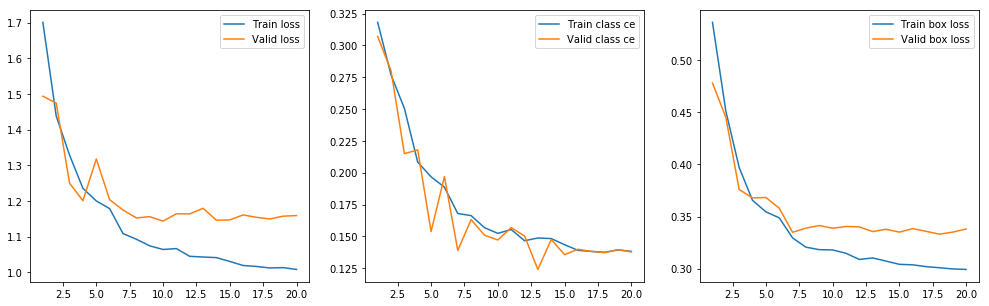

In [25]:
# Plot loss
epochs = range(1,len(next(iter(history.values())))+1)
df_history = pd.DataFrame(history, index=epochs)

plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [26]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1)

Best Epoch: 10


In [27]:
df_history

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.701090,0.536087,0.318150,0.401674,0.421857,0.023320,1.493952,0.477904,0.307128,0.377879,0.312242,0.018798
2,1.438129,0.451055,0.276909,0.380668,0.312980,0.016515,1.474605,0.445089,0.280111,0.382792,0.349919,0.016692
3,1.328699,0.397020,0.250601,0.380128,0.288534,0.012407,1.249895,0.375869,0.215041,0.360469,0.287222,0.011286
4,1.235538,0.365490,0.208345,0.376395,0.275283,0.010018,1.201053,0.367860,0.217957,0.352240,0.252942,0.010047
5,1.200406,0.354510,0.196851,0.372916,0.266928,0.009193,1.317991,0.368264,0.153867,0.375326,0.409722,0.010806
6,1.178796,0.348787,0.188699,0.371705,0.260980,0.008618,1.203956,0.358027,0.197062,0.358214,0.281148,0.009497
7,1.108840,0.329528,0.167998,0.364308,0.239581,0.007417,1.174872,0.334874,0.139049,0.354953,0.336868,0.009120
8,1.092987,0.320631,0.166383,0.361656,0.237172,0.007137,1.152674,0.338891,0.163246,0.353017,0.289041,0.008470
9,1.074479,0.318264,0.156904,0.361501,0.230828,0.006974,1.156276,0.341385,0.151034,0.354859,0.300571,0.008419
10,1.064192,0.317982,0.152437,0.361011,0.226042,0.006713,1.143708,0.338799,0.147235,0.354255,0.295413,0.007999


In [23]:
df_history.to_csv('df_history.csv', index=False)